In [63]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Input
from sklearn.linear_model import LinearRegression

In [64]:
# Konfigurasi saham yang akan diprediksi
STOCK_TICKER = "AAPL"
PREDICTION_DAYS = 30
PERIOD = "5y"
SEQUENCE_LENGTH = 60

In [65]:
# Fungsi untuk mendapatkan data saham dari Yahoo Finance
def get_stock_data(ticker, period=PERIOD):
    stock = yf.Ticker(ticker)
    hist = stock.history(period=period)
    time.sleep(2)
    return hist

In [66]:
stock_data = get_stock_data(STOCK_TICKER)
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-05-21 00:00:00-04:00,77.439891,77.981822,76.761871,77.000031,102688800,0.0,0.0
2020-05-22 00:00:00-04:00,76.737553,77.578398,76.635490,77.495773,81803200,0.0,0.0
2020-05-26 00:00:00-04:00,78.616088,78.795918,76.914967,76.970863,125522000,0.0,0.0
2020-05-27 00:00:00-04:00,76.827469,77.452018,76.086262,77.306206,112945200,0.0,0.0
2020-05-28 00:00:00-04:00,76.980595,78.601524,76.703559,77.340263,133560800,0.0,0.0
...,...,...,...,...,...,...,...
2025-05-14 00:00:00-04:00,212.429993,213.940002,210.580002,212.330002,49325800,0.0,0.0
2025-05-15 00:00:00-04:00,210.949997,212.960007,209.539993,211.449997,45029500,0.0,0.0
2025-05-16 00:00:00-04:00,212.360001,212.570007,209.770004,211.259995,54737900,0.0,0.0


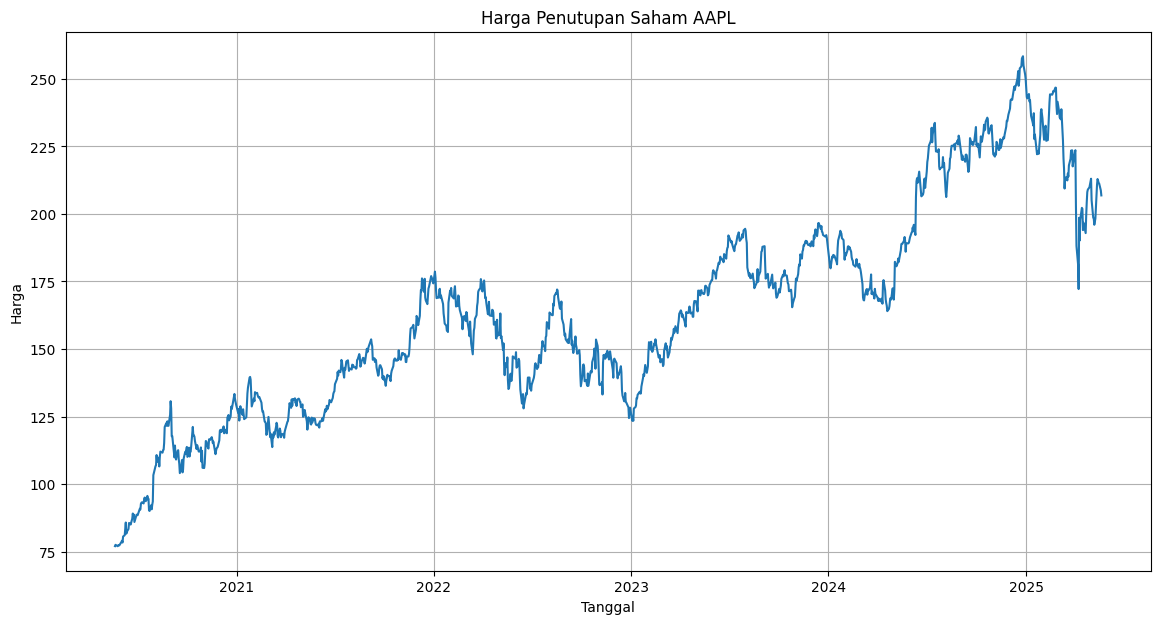

In [67]:
# Melihat pergerakan harga saham
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'])
plt.title(f'Harga Penutupan Saham {STOCK_TICKER}')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.grid(True)
plt.show()

In [68]:
def prepare_data_for_lstm(data, sequence_length=SEQUENCE_LENGTH):
    data_close = data['Close'].values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_close)

    X_train = []
    y_train = []
    all_dates = []

    for i in range(sequence_length, len(data_scaled)):
        X_train.append(data_scaled[i-sequence_length:i, 0])
        y_train.append(data_scaled[i, 0])
        all_dates.append(data.index[i])

    train_size = int(len(X_train) * 0.8)

    xt_train = X_train[:train_size]
    xt_val = X_train[train_size:]
    Yl_train = y_train[:train_size]
    Yl_val = y_train[train_size:]

    train_dates = all_dates[:train_size]
    val_dates = all_dates[train_size:]

    # Konversi list ke numpy array
    X_train, y_train = np.array(xt_train), np.array(Yl_train)
    X_val, y_val = np.array(xt_val), np.array(Yl_val)

    # Reshape data untuk LSTM [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

    return scaler, data_scaled, X_train, y_train, X_val, y_val, train_dates, val_dates


In [69]:
scaler, data_scaled, X_train, y_train, X_val, y_val, train_dates, val_dates = prepare_data_for_lstm(stock_data)

In [70]:
# Fungsi untuk membuat beberapa model berbeda
def create_ensemble_models(input_shape, num_features=1):
    # Model 1: LSTM sederhana
    model1_input = Input(shape=input_shape)
    model1_lstm = LSTM(50)(model1_input)
    model1_dense = Dense(1)(model1_lstm)
    model1 = Model(inputs=model1_input, outputs=model1_dense, name='lstm_model')

    # Model 2: GRU
    model2_input = Input(shape=input_shape)
    model2_gru = GRU(50)(model2_input)
    model2_dense = Dense(1)(model2_gru)
    model2 = Model(inputs=model2_input, outputs=model2_dense, name='gru_model')

    # Model 3: Bidirectional LSTM
    model3_input = Input(shape=input_shape)
    model3_bilstm = Bidirectional(LSTM(25))(model3_input)
    model3_dense = Dense(1)(model3_bilstm)
    model3 = Model(inputs=model3_input, outputs=model3_dense, name='bilstm_model')

    # Compile masing-masing model
    models = [model1, model2, model3]
    for model in models:
        model.compile(optimizer='adam', loss='mean_squared_error')

    return models

In [71]:
# Fungsi untuk melatih setiap model
def train_ensemble_models(models, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    trained_models = []
    histories = []

    for i, model in enumerate(models):
        print(f"Training model {i+1}/{len(models)}: {model.name}")
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            verbose=1
        )
        trained_models.append(model)
        histories.append(history)

    return trained_models, histories

In [72]:
dl_models = create_ensemble_models((X_train.shape[1], 1))

In [73]:
trained_dl_models, histories = train_ensemble_models(dl_models, X_train, y_train, X_val, y_val)

Training model 1/3: lstm_model
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0378 - val_loss: 0.0189
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0017 - val_loss: 0.0066
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 8.7897e-04 - val_loss: 0.0023
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.8521e-04 - val_loss: 0.0021
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.5352e-04 - val_loss: 0.0020
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.2630e-04 - val_loss: 0.0020
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.4486e-04 - val_loss: 0.0020
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 7.1372e-04 - val_loss: 0.0021
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 8.0925e-04 - val_loss: 0.0018
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 7.0396e-04 - val_loss: 0.0018


In [74]:
individual_predictions_train = {}
for i, model in enumerate(trained_dl_models):
    pred = model.predict(X_train)
    individual_predictions_train[model.name] = pred.flatten()

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [75]:
individual_predictions_val = {}
for i, model in enumerate(trained_dl_models):
    pred = model.predict(X_val)
    individual_predictions_val[model.name] = pred.flatten()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [76]:
train_preds = list(individual_predictions_train.values())  # list of arrays
val_preds = list(individual_predictions_val.values())

X_stack_train = np.stack(train_preds, axis=1)
X_stack_val = np.stack(val_preds, axis=1)

In [77]:
print("Sample train_preds:", val_preds[0][:5])  # lihat 5 prediksi awal dari model pertama
print("X_stack_val shape:", X_stack_val.shape)
print("X_stack_val sample:", X_stack_val[:5])

Sample train_preds: [0.64147985 0.6483722  0.6509788  0.6566097  0.6538168 ]
X_stack_val shape: (240, 3)
X_stack_val sample: [[0.64147985 0.63895863 0.6323091 ]
 [0.6483722  0.6454569  0.6381721 ]
 [0.6509788  0.6442479  0.6408912 ]
 [0.6566097  0.65019876 0.64630765]
 [0.6538168  0.6419703  0.64492005]]


In [78]:
# Debug: Cetak 5 prediksi pertama untuk setiap model
for model_name, preds in individual_predictions_val.items():
    print(f"{model_name} predictions (first 5): {preds[:5]}")
    print(f"{model_name} prediction shape: {preds.shape}")
    print(f"{model_name} unique values: {np.unique(preds).shape[0]}")
    print("-" * 50)

# Verifikasi bentuk data
print(f"X_val shape: {X_val.shape}")

lstm_model predictions (first 5): [0.64147985 0.6483722  0.6509788  0.6566097  0.6538168 ]
lstm_model prediction shape: (240,)
lstm_model unique values: 240
--------------------------------------------------
gru_model predictions (first 5): [0.63895863 0.6454569  0.6442479  0.65019876 0.6419703 ]
gru_model prediction shape: (240,)
gru_model unique values: 240
--------------------------------------------------
bilstm_model predictions (first 5): [0.6323091  0.6381721  0.6408912  0.64630765 0.64492005]
bilstm_model prediction shape: (240,)
bilstm_model unique values: 240
--------------------------------------------------
X_val shape: (240, 60, 1)


In [79]:
# Model meta-ensemble
meta_model = LinearRegression()

meta_model.fit(X_stack_train, y_train)

LinearRegression()

In [80]:
# prediksi menggunakan meta model
ensemble_preds_hist_train = meta_model.predict(X_stack_train)
ensemble_preds_hist_val = meta_model.predict(X_stack_val)

In [81]:
# Fungsi untuk mengubah prediksi ensemble
def predict_ensemble(models, scaler, last_sequence, meta_model, prediction_days=30):

    ensemble_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(prediction_days):
        model_predictions = []
        current_sequence_reshaped = np.reshape(current_sequence, (1, current_sequence.shape[0], 1))

        # Prediksi dari setiap model
        for model in models:
            next_day = model.predict(current_sequence_reshaped, verbose=0)[0][0]
            model_predictions.append(next_day)

        # prediksi dari semua model
        model_predictions = np.array(model_predictions).reshape(1, -1)

        next_day_ensemble = meta_model.predict(model_predictions)[0]

        # Tambahkan sedikit noise
        noise = np.random.normal(0, 0.002, 1)[0]
        next_day_ensemble += noise

        # Tambahkan ke hasil prediksi
        ensemble_predictions.append(next_day_ensemble)

        # output akhir
        current_sequence = np.append(current_sequence[1:], next_day_ensemble)

    # Mengembalikan nilai ke skala asli
    ensemble_predictions_scaled = np.array(ensemble_predictions).reshape(-1, 1)
    ensemble_predictions_original = scaler.inverse_transform(ensemble_predictions_scaled)

    return ensemble_predictions_original

In [82]:
last_date = stock_data.index[-1]

In [83]:
last_sequence = data_scaled[-SEQUENCE_LENGTH:]
future_predictions_base = predict_ensemble(
    trained_dl_models, scaler, last_sequence, meta_model)

In [84]:
future_dates = []
current_date = last_date
while len(future_dates) < PREDICTION_DAYS:
    current_date += datetime.timedelta(days=1)
    if current_date.weekday() < 5:
        future_dates.append(current_date)

In [85]:
def plot_ensemble_predictions(data, scaler, train_dates, val_dates,
                              individual_predictions_train, individual_predictions_val,
                              ensemble_predictions_train, ensemble_predictions_val,
                              future_dates, future_predictions, ticker):

    plt.figure(figsize=(14, 8))

    # Plot data historis (aktual)
    plt.plot(data.index, data['Close'], label='Harga Aktual', color='blue', linewidth=2)

    # Plot prediksi dari model-model individual
    colors = ['lightgray', 'darkgray', 'silver', 'gray']
    # Untuk model individual
    for i, (model_name, preds_train) in enumerate(individual_predictions_train.items()):
        # Plot prediksi train
        plt.plot(train_dates, scaler.inverse_transform(preds_train.reshape(-1, 1)),
                label=f'{model_name} (Train)', color=colors[i % len(colors)],
                alpha=0.4, linewidth=1, linestyle='--')

        # Plot prediksi validasi jika ada
        if model_name in individual_predictions_val:
            plt.plot(val_dates, scaler.inverse_transform(individual_predictions_val[model_name].reshape(-1, 1)),
                    label=f'{model_name} (Val)', color=colors[i % len(colors)],
                    alpha=0.7, linewidth=1, linestyle='-.')

    # Plot ensemble train dan val
    plt.plot(train_dates, scaler.inverse_transform(ensemble_predictions_train.reshape(-1, 1)), label='Ensemble (Train)', color='green', linewidth=2)
    plt.plot(val_dates, scaler.inverse_transform(ensemble_predictions_val.reshape(-1, 1)), label='Ensemble (Val)', color='red', linewidth=2, linestyle='--')

    # Plot prediksi masa depan
    plt.plot(future_dates, future_predictions, label='Prediksi masa depan', color='orange', linewidth=2)

    # Garis vertikal untuk hari terakhir aktual
    latest_date = data.index[-1]
    plt.axvline(x=latest_date, color='black', linestyle='--', label='Hari Ini')

    # Judul dan label
    plt.title(f'Prediksi Ensemble Harga Saham {ticker} - 30 Hari ke Depan',
              fontsize=16)
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Harga Saham', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(f"{ticker}_ensemble_prediction.png", dpi=300)
    plt.show()


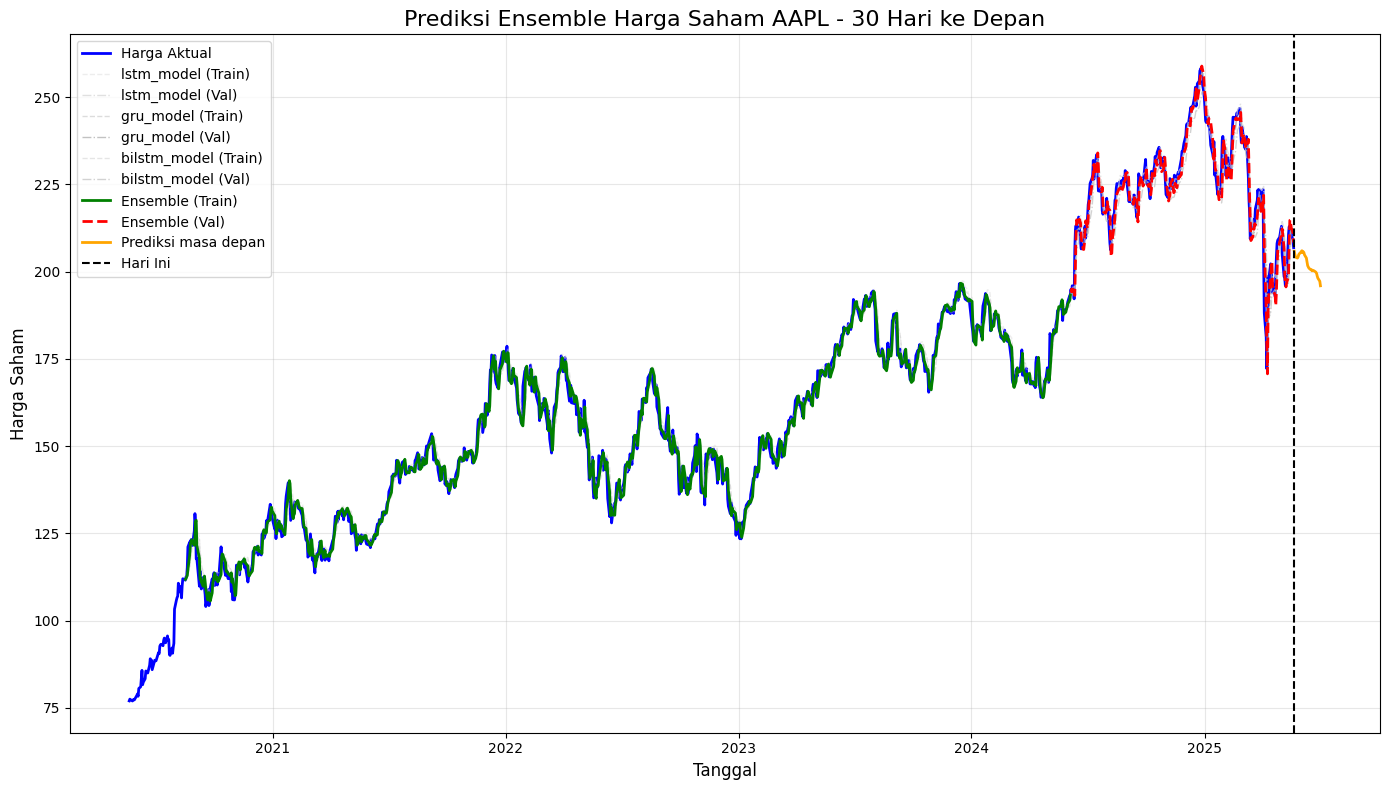

In [86]:
plot_ensemble_predictions(
    stock_data, scaler, train_dates, val_dates, individual_predictions_train,
    individual_predictions_val, ensemble_preds_hist_train, ensemble_preds_hist_val,
    future_dates, future_predictions_base, STOCK_TICKER,
)

In [87]:
# Menampilkan hasil prediksi masa depan dalam bentuk DataFrame
df_prediksi_masa_depan = pd.DataFrame({
    'Tanggal': future_dates,
    'Prediksi Harga': future_predictions_base.flatten()
})
df_prediksi_masa_depan.set_index('Tanggal', inplace=True)
df_prediksi_masa_depan


,Prediksi Harga
Tanggal,
2025-05-21 00:00:00-04:00,205.858208
2025-05-22 00:00:00-04:00,204.931204
2025-05-23 00:00:00-04:00,204.197163
2025-05-26 00:00:00-04:00,203.904275
2025-05-27 00:00:00-04:00,204.235513
2025-05-28 00:00:00-04:00,204.895321
2025-05-29 00:00:00-04:00,205.188104
2025-05-30 00:00:00-04:00,205.309877
2025-06-02 00:00:00-04:00,206.017698


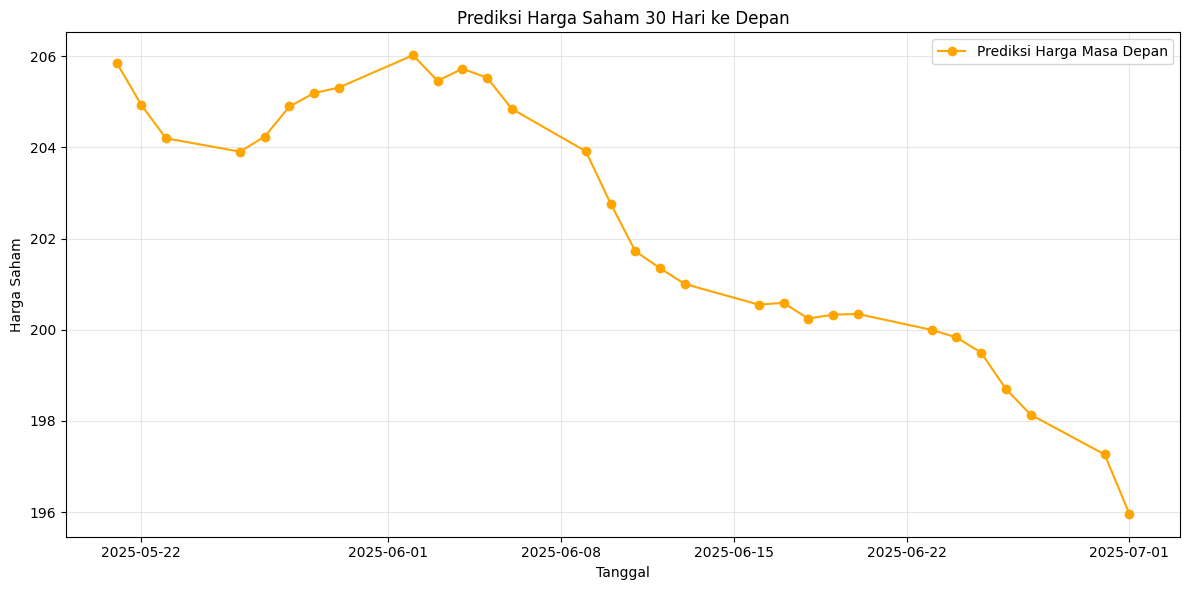

In [88]:
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions_base, marker='o', color='orange', label='Prediksi Harga Masa Depan')
plt.title('Prediksi Harga Saham 30 Hari ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('Harga Saham')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [89]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

mape = mean_absolute_percentage_error(y_val, ensemble_preds_hist_val)
mae = mean_absolute_error(y_val, ensemble_preds_hist_val)
mse = mean_squared_error(y_val, ensemble_preds_hist_val)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, ensemble_preds_hist_val)

print(f"Evaluasi hasil prediksi pada Data Validasi:")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.4f}%")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R2   : {r2:.4f}")


Evaluasi hasil prediksi pada Data Validasi:
MAE  : 0.0189
MAPE : 2.4152%
MSE  : 0.0007
RMSE : 0.0263
R2   : 0.8955
